# Scaling mega-pixel images classification via attention sampling
## Lymphoma subtype case study

In order to make this project work, prepare the dataset as follows:
```
. # current directory
|- this ipynb file
|- dataset
   |- CLL
   |  |- images for CLL class
   |- FL
   |  |- images for FL class
   |- MCL
      |- images for MCL class
```

In [29]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image
import json
import matplotlib.pyplot as plt

In [2]:
# load data from cache / raw files
LOAD_FROM_MEM_DATASET = False
# load data from previous checkpoints / random initialization
LOAD_FROM_MEM_MODELS = False
# number of patches that the model should sample
NUM_PATCHES = 5
# size (w&h) of the patches
PATCH_SIZE = 50
# scaling factor for the attention model
ATTENTION_SCALING_FACTOR = 5
# Entropy coefficient for attention model
ENTROPY_COEF = 0.05
# random crop to simplify sampling
IMAGE_SIZE = (1000, 1300, 3)
# if use bounded reward or unbounded reward
BOUNDED_REWARD = True
# number of times to repeat each batch
REPEAT_BATCH = 4
# training hyper parameters
NUM_CLASSES = 3
EPOCHS = 30
BATCH_SIZE = 8
TEMPERATURE = 3.

## Dataset loading

In [3]:
# loading dataset
if LOAD_FROM_MEM_DATASET:
    FL_paths = list(os.listdir("./dataset/FL"))
    CLL_paths = list(os.listdir("./dataset/CLL"))
    MCL_paths = list(os.listdir("./dataset/MCL"))
    FL_images = np.array([np.array(Image.open(f"./dataset/FL/{el}")) for el in FL_paths])
    CLL_images = np.array([np.array(Image.open(f"./dataset/CLL/{el}")) for el in CLL_paths])
    MCL_images = np.array([np.array(Image.open(f"./dataset/MCL/{el}")) for el in MCL_paths])
    labels = np.concatenate((
        np.full((FL_images.shape[0],), 0),
        np.full((CLL_images.shape[0],), 1),
        np.full((MCL_images.shape[0],), 2)
    ))
    data = np.concatenate((
        FL_images,
        CLL_images,
        MCL_images
    ))
    with open("./cache/labels", "wb+") as file:
        np.save(file, labels)
    with open("./cache/data", "wb+") as file:
        np.save(file, data)
else:
    with open("./cache/labels", "rb") as file:
        labels = np.load(file)
    with open("./cache/data", "rb") as file:
        data = np.load(file)

In [ ]:
# random shuffling the data 70/15/15 (train/val/test)
perm = np.random.permutation(len(data))
data = data[perm]
labels = labels[perm]
data_train = data[:int(len(data) * 0.7)]
labels_train = labels[:int(len(labels) * 0.7)]
data_val = data[int(len(data) * 0.7):int(len(data) * 0.85)]
labels_val = labels[int(len(labels) * 0.7):int(len(labels) * 0.85)]
data_test = data[int(len(data) * 0.85):]
labels_test = labels[int(len(labels) * 0.85):]

In [ ]:
# creating train/val/test dataset
val_dataset = (
    tf.data.Dataset.from_tensor_slices((data_val, labels_val))
       .shuffle(500)
       .batch(BATCH_SIZE)
       .map(lambda x, y: (tf.cast(x, tf.float32), y))
       .map(lambda x, y: (tf.clip_by_value(x, 0., 255.) / 255., y))
       .map(lambda x, y: (tf.image.random_crop(x, (tf.shape(x)[0], 1000, 1300, 3)), y))
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices((data_test, labels_test))
        .shuffle(500)
        .batch(BATCH_SIZE)
        .map(lambda x, y: (tf.cast(x, tf.float32), y))
        .map(lambda x, y: (tf.clip_by_value(x, 0., 255.) / 255., y))
        .map(lambda x, y: (tf.image.random_crop(x, (tf.shape(x)[0], 1000, 1300, 3)), y))
)

# the training dataset has the additional data augmentation steps
random_zoom = tf.keras.layers.RandomZoom((0., 0.6))
train_dataset = (
    tf.data.Dataset.from_tensor_slices((data_train, labels_train))
         .shuffle(500)
         .batch(BATCH_SIZE)
         .map(lambda x, y: (tf.cast(x, tf.float32), y))
         .map(lambda x, y: (tf.image.random_flip_left_right(x), y))
         .map(lambda x, y: (tf.image.random_contrast(x, 0.99, 0.999), y))
         .map(lambda x, y: (tf.clip_by_value(x, 0., 255.) / 255., y))
         .map(lambda x, y: (tf.image.random_crop(x, (tf.shape(x)[0], 1000, 1300, 3)), y))
         .map(lambda x, y: (random_zoom(x), y))
)

## Models

In [ ]:
# create folder for storing model history
FOLDER_NAME = f"./model/{NUM_PATCHES:03.0f}_patches-{PATCH_SIZE:03.0f}_pixels-{ATTENTION_SCALING_FACTOR:03.0f}_attention_scaling_factor"
os.makedirs(FOLDER_NAME, exist_ok=True)

In [6]:
# custom softmax activation over 2 axis (w&h)
def multi_dimension_softmax(tensor):
    e_t = tf.exp(tensor)
    total = tf.reduce_sum(e_t, axis=(1, 2, 3), keepdims=True)
    return e_t / total

# attention network with local FOV and multi layer softmax in the final layer
attention_network = tf.keras.Sequential([
    tf.keras.layers.AveragePooling2D(ATTENTION_SCALING_FACTOR),
    tf.keras.layers.Conv2D(8, 3, activation=tf.nn.leaky_relu, padding="SAME"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(8, 3, activation=tf.nn.leaky_relu, padding="SAME"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(8, 3, activation=tf.nn.leaky_relu, padding="SAME"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(1, 3, padding="SAME"),
    tf.keras.layers.Lambda(multi_dimension_softmax)
])
# feature network with normalized logits
feature_network = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, kernel_size=3, activation=tf.nn.leaky_relu, padding="SAME"),
    tf.keras.layers.Conv2D(16, kernel_size=3, activation=tf.nn.leaky_relu, padding="SAME"),
    tf.keras.layers.Conv2D(16, kernel_size=3, activation=tf.nn.leaky_relu, padding="SAME"),
    tf.keras.layers.Conv2D(16, kernel_size=3, activation=tf.nn.leaky_relu, padding="SAME"),
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Dense(NUM_CLASSES, activation="linear"),
    tf.keras.layers.Lambda(lambda t: tf.linalg.normalize(t, axis=-1)[0])
])
# classification "network"
def classification_network(features, probs):
    # groups feature logits in batches of size = # patch per image
    features_batched = tf.reshape(features, (-1, NUM_PATCHES, NUM_CLASSES))
    # reshapes the attention probabilities of the sampled patches
    probs_batched = tf.reshape(probs, (-1, NUM_PATCHES, 1))
    # calculates the normalization terms
    probs_batched_norm = tf.reduce_sum(probs_batched, axis=(1, 2), keepdims=True)
    # normalize the probabilities
    probs_batched_normalized = probs_batched / probs_batched_norm
    # calculate the final classification
    return tf.nn.softmax(TEMPERATURE * tf.reduce_sum(features_batched * probs_batched_normalized, axis=1))

In [ ]:
# load models and training data from memory
if LOAD_FROM_MEM_MODELS:
    try:
        epoch = int(input("epoch to load: "))
        attention_network.load_weights(f"{FOLDER_NAME}/training/{epoch:03.0f}/attention")
        feature_network.load_weights(f"{FOLDER_NAME}/training/{epoch:03.0f}/feature")
        with open(f"{FOLDER_NAME}/loss.txt", "rb+") as file:
            losses = json.load(file)
        with open(f"{FOLDER_NAME}/accuracy.txt", "rb+") as file:
            accuracies = json.load(file)
        with open(f"{FOLDER_NAME}/validation_loss.txt", "rb+") as file:
            validation_losses = json.load(file)
        with open(f"{FOLDER_NAME}/validation_accuracy.txt", "rb+") as file:
            validation_accuracies = json.load(file)
    except Exception as e:
        losses = []
        accuracies = []
        validation_losses = []
        validation_accuracies = []
        print(f"Weights not found: {e}")
else:
    losses = []
    accuracies = []
    validation_losses = []
    validation_accuracies = []

## Forward pass

In [ ]:
def forward(x_batch):
    # calculate attention scores per images
    attention = attention_network(x_batch)
    flatten = tf.reshape(attention, (attention.shape[0], -1))
    # sample from a categorical distribution the patches ID
    sampled = tf.random.categorical(tf.math.log(flatten), NUM_PATCHES, dtype=tf.int32)
    sampled_indexes = tf.reshape(
        tf.concat((
            tf.repeat(tf.range(sampled.shape[0])[..., None], sampled.shape[1], axis=-1)[..., None],
            sampled[..., None]
        ), axis=-1),
        (-1, 2)
    )
    # gather the probabilities of the respective sampled patches
    selected_patches_probs = tf.gather_nd(flatten, sampled_indexes)

    """
        Patches sampling procesures:
            1) find image indexes, calculating x&y coordinate using modulos and integer divisions
            2) pair coordinates of the patches [[x1,y1], [x2,y2], ...]
            3) calculate the patch "mask", thus given (for example) patch size 3, we are interested in:
                        [
                            [-1,-1], [0,-1], [1,-1],
                            [-1, 0], [0, 0], [1, 0],
                            [-1, 1], [0, 1], [1, 1],
                        ]
                thus the 3x3 local neighborhood of the central pixel
            4) move the "mask" in the desired locations (coordinate-wise), thus using coordinate*scaling+mask:

                                       [[-1,-1], [0,-1], [1,-1],
                           [30,24]*5 +  [-1, 0], [0, 0], [1, 0],
                                        [-1, 1], [0, 1], [1, 1]]
                thus converting the coordinate in the scaled size version, in the original size version, and
                finding the indexes of the local neighborhood

    """
    # 1
    sampled = sampled.numpy().reshape((-1,))
    x = (sampled % attention.shape[2]).reshape((-1, NUM_PATCHES, 1))
    y = (sampled // attention.shape[2]).reshape((-1, NUM_PATCHES, 1))

    # 2
    pairs = np.concatenate((y, x), axis=-1)

    # 3
    mask = np.argwhere(np.ones((PATCH_SIZE, PATCH_SIZE)) == 1).T[None, None, ...] - PATCH_SIZE//2

    #4
    indexes = ((pairs * ATTENTION_SCALING_FACTOR)[..., None] + mask)

    # generate patches looping over images and indexes
    patches = []
    for image, patches_index in zip(x_batch.numpy(), indexes):

        # concat new patch
        patches += [
            # pad the image, so that if the center is near the border, it doesn't get out of bound
            np.pad(image, (
                    # top & bottom padding
                    (PATCH_SIZE, PATCH_SIZE),
                    # left & right padding
                    (PATCH_SIZE, PATCH_SIZE),
                    # channel padding (not needed)
                    (0, 0)
                ), mode="reflect" # how to fill the image
           )[index[0]+PATCH_SIZE, index[1]+PATCH_SIZE].reshape( # get only the interested area and reshape it back to a square
                (PATCH_SIZE, PATCH_SIZE, 3)
            )
            for index in patches_index
        ]

    patches = np.array(patches)

    # calculate the normalized logits
    features = feature_network(patches)

    # calculate the predictions
    predictions = classification_network(features, tf.stop_gradient(selected_patches_probs))

    return predictions, selected_patches_probs, attention, flatten

## Training

In [ ]:
# since the nets are not so deep, we can use a large batch size
optimizer_attention = tf.optimizers.legacy.Adam(1e-3)
optimizer_feature = tf.optimizers.legacy.Adam(1e-3)

# train loop
for epoch in range(EPOCHS):
    print(f"Epoch {epoch} / {EPOCHS}")

    # preparing metrics for the training evaluation
    mean_loss = tf.keras.metrics.Mean()
    mean_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    for x_batch, y_batch in train_dataset:
        print(".", end="")

        # repeat batches tu consider them multiple times
        x_batch = tf.repeat(x_batch, REPEAT_BATCH, axis=0)
        y_batch = tf.repeat(y_batch, REPEAT_BATCH, axis=0)

        with tf.GradientTape(persistent=True) as tape:

            # forward propagate the batch
            predictions, selected_patches_probs, attention, flatten = forward(x_batch)

            # calculate the loss for feature network/for each image
            loss_feature = tf.losses.sparse_categorical_crossentropy(y_batch, predictions)

            # calculate average entropy for each image
            attention_entropy = tf.reduce_sum(tf.math.log(flatten) * flatten) / tf.cast(tf.shape(x_batch)[0], tf.float32)

            # calculate the reward for the attention network with baseline
            if BOUNDED_REWARD:
                processed_reward = tf.exp(-loss_feature)
                reward = -(processed_reward - tf.reduce_mean(processed_reward))[..., None]
            else:
                reward = -(loss_feature - tf.reduce_mean(loss_feature))[...,None]

            # calculate the policy gradient loss for the attention network
            loss_attention = tf.math.log(
                tf.reshape(selected_patches_probs, (-1, NUM_PATCHES))) * reward + ENTROPY_COEF * attention_entropy

            # average loss for networks to make the magnitude batch invariant
            mean_loss.update_state(tf.reduce_mean(loss_feature))
            mean_accuracy.update_state(y_batch, predictions)

        # calculate gradient of the losses wrt the networks parameters
        grad_attention_network = tape.gradient(loss_attention, attention_network.trainable_weights)
        grad_feature_network = tape.gradient(loss_feature, feature_network.trainable_weights)

        # back-propagate gradient through the networks
        optimizer_attention.apply_gradients(zip(grad_attention_network, attention_network.trainable_weights))
        optimizer_feature.apply_gradients(zip(grad_feature_network, feature_network.trainable_weights))

        # print training information up until the current batch
        print(f"\rloss : {mean_loss.result()} - accuracy : {mean_accuracy.result()}", end="")

    # preparing metrics for the validation evaluation
    val_mean_loss = tf.keras.metrics.Mean()
    val_mean_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    # loop over validation set
    for x, y in val_dataset:
        predictions, *_ = forward(x)
        val_mean_loss.update_state(tf.reduce_mean(tf.losses.sparse_categorical_crossentropy(y, predictions)))
        val_mean_accuracy.update_state(y, predictions)

    # print validation metrics
    print(f" - val_loss : {val_mean_loss.result()} - val_accuracy : {val_mean_accuracy.result()}")

    # store metrics
    losses.append(float(mean_loss.result().numpy()))
    accuracies.append(float(mean_accuracy.result().numpy()))
    validation_losses.append(float(val_mean_loss.result().numpy()))
    validation_accuracies.append(float(val_mean_accuracy.result().numpy()))

    # save models for later evaluation
    attention_network.save_weights(f"{FOLDER_NAME}/training/{epoch:03.0f}/attention")
    feature_network.save_weights(f"{FOLDER_NAME}/training/{epoch:03.0f}/feature")

    # save metrics for later evaluation
    with open(f"{FOLDER_NAME}/loss.txt", "w+") as file:
        json.dump(losses, file)
    with open(f"{FOLDER_NAME}/accuracy.txt", "w+") as file:
        json.dump(accuracies, file)
    with open(f"{FOLDER_NAME}/validation_loss.txt", "w+") as file:
        json.dump(validation_losses, file)
    with open(f"{FOLDER_NAME}/validation_accuracy.txt", "w+") as file:
        json.dump(validation_accuracies, file)

## Training result

In [ ]:
losses = np.array(losses)
validation_losses = np.array(validation_losses)
accuracies = np.array(accuracies)
validation_accuracies = np.array(validation_accuracies)

In [ ]:
# plot losses
plt.plot(losses)
plt.plot(validation_losses)
plt.legend(["loss", "val loss"])
plt.show()

# plot accuracies
plt.plot(accuracies)
plt.plot(validation_accuracies)
plt.legend(["accuracy", "val accuracy"])
plt.show()

In [12]:
# smooth accuracies for reduce noise in the plots
acc_ = []
for i in range(1, len(accuracies)):
    acc_.append((accuracies[i-1] + accuracies[i])/2)
val_acc_ = []
for i in range(1, len(validation_accuracies)):
    val_acc_.append((validation_accuracies[i-1] + validation_accuracies[i])/2)

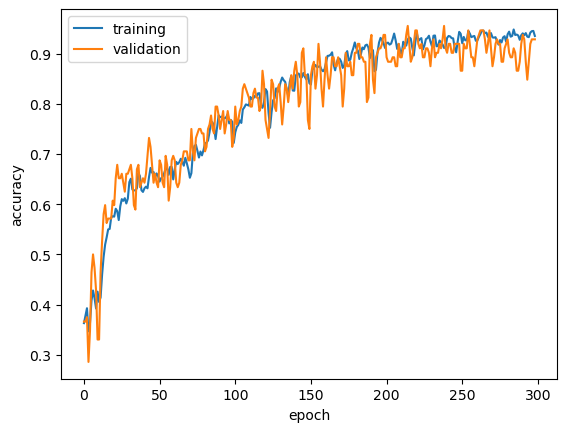

In [16]:
plt.plot(acc_)
plt.plot(val_acc_)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["training", "validation"])

In [18]:
# smooth losses for reduce noise in the plots
loss_ = []
for i in range(1, len(losses)):
    loss_.append((losses[i-1] + losses[i])/2)
val_loss_ = []
for i in range(1, len(validation_losses)):
    val_loss_.append((validation_losses[i-1] + validation_losses[i])/2)

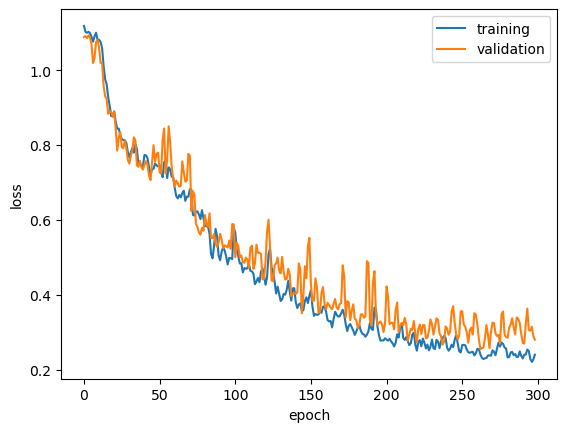

In [20]:
plt.plot(loss_)
plt.plot(val_loss_)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["training", "validation"])